In [44]:
from __future__ import print_function
from six.moves import range

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
import time
import sys
import warnings
import os
import pickle
import pandas as pd
import PIL
from tqdm import tqdm_notebook
from keras.applications.inception_v3 import preprocess_input
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from miscc.config import cfg, cfg_from_file
from PIL import Image
import datetime
import dateutil.tz
from keras.datasets import cifar100
from model import CNN_ENCODER_BASE
# from InceptionScore import calculate_inception_score
import torchvision.transforms as transforms
from scipy.linalg import sqrtm
import torchvision.models as models
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from scipy.special import softmax

In [2]:
with open('../data/cifar/cifar_labels.pickle','rb') as f:
    cifar_mapping = pickle.load(f)
clabel_texts = cifar_mapping['coarse_label']
mlabel_texts = cifar_mapping['mapping']

In [3]:
# def cosine_similarity(x1, x2, dim=1, eps=1e-8):
#     """Returns cosine similarity between x1 and x2, computed along dim.
#     """
#     w12 = np.sum(x1 * x2, dim)
#     w1 = np.linalg.norm(x1, 2, dim)
#     w2 = np.linalg.norm(x2, 2, dim)
#     return (w12 / np.clip(w1 * w2,a_min=eps,a_max=1e8)).squeeze()

In [4]:
class parse_args():
    cfg_file='../code/cfg/coco_attn2.yml'
    gpu_id=0
    data_dir='../data/coco/'
    manualSeed=1
args = parse_args()

In [5]:
def w2i(w=''):
    return [i for i, val in enumerate(np.array(clabel_texts)==w) if val]
def id2imgidx(i=0):
    return [i for i, val in enumerate(y_test==i) if val]
def fid(act1,act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [6]:
args = parse_args()
if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)

if args.gpu_id == -1:
    cfg.CUDA = False
else:
    cfg.GPU_ID = args.gpu_id

if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir
    

print('Using config:')
display(cfg)

split_dir, bshuffle = 'train', True
if not cfg.TRAIN.FLAG:
    # bshuffle = False
    split_dir = 'test'

Using config:


{'DATASET_NAME': 'coco',
 'CONFIG_NAME': 'glu-gan2',
 'DATA_DIR': '../data/coco/',
 'GPU_ID': 0,
 'CUDA': True,
 'WORKERS': 4,
 'RNN_TYPE': 'LSTM',
 'B_VALIDATION': False,
 'TREE': {'BRANCH_NUM': 3, 'BASE_SIZE': 64},
 'TRAIN': {'BATCH_SIZE': 14,
  'MAX_EPOCH': 150,
  'SNAPSHOT_INTERVAL': 2,
  'DISCRIMINATOR_LR': 0.0002,
  'GENERATOR_LR': 0.0002,
  'ENCODER_LR': 0.0002,
  'RNN_GRAD_CLIP': 0.25,
  'FLAG': True,
  'NET_E': '../DAMSMencoders/coco/text_encoder240.pth',
  'NET_G': '../output/coco_glu-gan2_2020_10_25_15_48_15/Model/netG_epoch_130.pth',
  'B_NET_D': True,
  'SMOOTH': {'GAMMA1': 4.0, 'GAMMA3': 10.0, 'GAMMA2': 5.0, 'LAMBDA': 50.0}},
 'GAN': {'DF_DIM': 96,
  'GF_DIM': 48,
  'Z_DIM': 100,
  'CONDITION_DIM': 100,
  'R_NUM': 3,
  'B_ATTENTION': True,
  'B_DCGAN': False},
 'TEXT': {'CAPTIONS_PER_IMAGE': 5, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 15}}

In [7]:
# imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
# imsize*76/64

In [8]:
# imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
# image_transform = transforms.Compose([
#     transforms.Scale(int(imsize * 76 / 64)),
#     transforms.RandomCrop(imsize),
#     transforms.RandomHorizontalFlip()])
# dataset = TextDataset(cfg.DATA_DIR, split_dir,
#                       base_size=cfg.TREE.BASE_SIZE,
#                       transform=image_transform)
# assert dataset

In [26]:
text_encoder = SentenceTransformer('bert-base-nli-mean-tokens')
image_encoder = CNN_ENCODER_BASE()

Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth


In [12]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [13]:
selected_id = w2i('aquarium_fish')[0]
ids = id2imgidx(selected_id)

In [14]:
# imgs = []
# for im in x_test[ids]:
#     imgs.append(np.asarray(Image.fromarray(im).resize((299,299),PIL.Image.ANTIALIAS),dtype=np.float32))
# imgs = np.array(imgs)

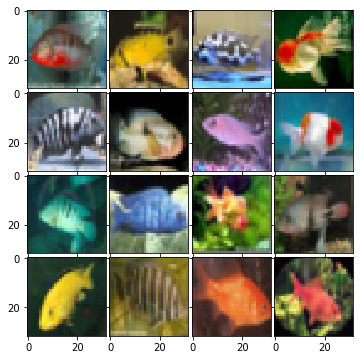

aquarium_fish


In [15]:


im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
         )

for ax, im in zip(grid, x_test[ids][:16]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()
print(clabel_texts[selected_id])

In [16]:
imgs = preprocess_input(x_test[ids])

In [17]:
imgs.min(),imgs.max()

(-1.0, 1.0)

In [18]:
# print(imgs.shape)
# i = np.rollaxis(imgs,axis=3,start=1)
# i = np.asarray(i,dtype=np.float32)
# print(i.shape)

In [19]:
imgs = []
for im in x_test[ids]:
    imgs.append(np.asarray(Image.fromarray(im).resize((299,299),PIL.Image.ADAPTIVE),dtype=np.float32))
imgs = np.array(imgs)
imgs = preprocess_input(imgs)
print(imgs.shape)
i = np.rollaxis(imgs,axis=3,start=1)
i = np.asarray(i,dtype=np.float32)
print(i.shape)
img_inp = torch.tensor(i)
print(img_inp.shape)

(100, 299, 299, 3)
(100, 3, 299, 299)
torch.Size([100, 3, 299, 299])


In [20]:
img_inp = torch.tensor(i[:10])

In [21]:
img_inp.size()


torch.Size([10, 3, 299, 299])

In [24]:
i_emb = image_encoder(img_inp)
i_emb = F.avg_pool2d(input=i_emb,kernel_size=17)
i_emb = i_emb.view(i_emb.size(0), -1)

print(i_emb.shape)

torch.Size([10, 768])


In [ ]:
i_emb.shape

In [ ]:
i_emb = np.asarray(i_emb.detach().cpu())


In [ ]:
selected_id = w2i('bus')[0]
print(selected_id)
print(clabel_texts[selected_id])
t_inp = [dataset.wordtoix[x] for x in [clabel_texts[selected_id]]]
text_inp = torch.tensor(np.array([t_inp])).cuda()
print(text_inp)

In [ ]:
w_emb,s_emb = text_encoder(text_inp)

In [ ]:
w_emb.shape, s_emb.shape

In [ ]:
s_emb = np.asarray(s_emb.detach().cpu())


In [ ]:
s_emb.shape,i_emb.shape

In [ ]:
# [x for x in zip(emb,w_emb[0])]

In [ ]:
sims = []
for emb in i_emb:
    sims.append(cosine_similarity([emb],s_emb))
# sims

In [ ]:
fid(s_emb,np.array(i_emb))

In [ ]:
df = pd.DataFrame()
df['sims'] = [float(x) for x in sims]

In [ ]:
# list(sims)
df.describe()

In [ ]:
df.describe().T['mean'].values[0]

In [ ]:
clabel_texts[2]='baby'

In [80]:
# keys = list(dataset.wordtoix.keys())
result = {}
for word in tqdm_notebook(clabel_texts):
    if '_' in word:
        word_ = word.split('_')[1]
    else:
        word_ = word
    result[word+'_img']={}
    selected_id = w2i(word)[0]
    ids = id2imgidx(selected_id)
    imgs = []
    for im in x_test[ids]:
        imgs.append(np.asarray(Image.fromarray(im).resize((299,299),PIL.Image.ADAPTIVE),dtype=np.float32))
    imgs = np.array(imgs)
    imgs = preprocess_input(imgs)
    i = np.rollaxis(imgs,axis=3,start=1)
    i = np.asarray(i,dtype=np.float32)
    img_inp = torch.tensor(i)
    i_emb = image_encoder(img_inp)
    i_emb = F.avg_pool2d(input=i_emb,kernel_size=17)
    i_emb = i_emb.view(i_emb.size(0), -1)
    i_emb = np.asarray(i_emb.detach().cpu())  

    for w in tqdm_notebook(clabel_texts,leave=False):
        if '_' in w:
            w_ = w.split('_')
        else:
            w_ = [w]
        result[word+'_img'][w] = {}
        
        s_emb = text_encoder.encode(' '.join(w_))
        sims = []
        for emb in i_emb:
            sims.append(cosine_similarity([emb],[s_emb]))
        df = pd.DataFrame()
        df['sims'] = [float(x) for x in sims]
        result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
        result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
        result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [ ]:
pd.read_csv('../')

In [81]:
# def highlight_max(data, color='lightgreen'):
#     '''
#     highlight the maximum in a Series or DataFrame
#     '''
#     attr = 'background-color: {}'.format(color)
#     #remove % and cast to float
#     data = data.replace('%','', regex=True).astype(float)
#     if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
#         is_max = data == data.max()
#         return [attr if v else '' for v in is_max]
#     else:  # from .apply(axis=None)
#         is_max = data == data.max().max()
#         return pd.DataFrame(np.where(is_max, attr, ''),
#                             index=data.index, columns=data.columns['c_sim_mean'])

In [82]:
pd.options.display.max_rows = 100
dict_of_df = {k: pd.DataFrame(v).T for k,v in result.items()}
df_result = pd.concat(dict_of_df, axis=1)


In [83]:
# img_keys = np.unique([k[0] for k in df_result.keys()])

In [84]:
# for k in img_keys:
#     df_result[k]['fid'] = np.around(softmax(df_result['apple_img']['fid'].values),4)

In [85]:
# df_result

In [86]:
subset=[]
for i in list(df_result.keys()):
    if 'c_sim_mean' in i:
        subset.append(i)

In [87]:
df_style = df_result.style.highlight_max(color = 'lightgreen', axis = 0,subset = subset)

In [88]:
df_style

In [89]:
df_style.to_excel('../plots/cifar_representation_baseline_results.xlsx')

In [ ]:
key = 'elephant_img'

In [ ]:
colors = []
sim_list = df_result[key]['c_sim_mean']
max_val = sim_list.max()
for sim in sim_list:
    if max_val == sim:
        colors.append('lightgreen')
    else:
        colors.append('lightblue')

In [ ]:
df_result[key]

In [ ]:
ax = df_result[key]['c_sim_mean'].plot(kind='barh'
                                  , color=colors
                                    ,stacked=True
                             ,figsize=(8,24)
                             ,grid=True,width=0.9
                             ,title='Cosine Similarity of Representation Image of "'+key.split('_')[0]+'" \n with various "Textual Keywords"')

ax.set_xlabel("Avg. Cosine Similarity with representation of 100 RGB images of "+key.split('_')[0])
ax.set_ylabel("Textual Keywords")
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(width), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')

In [101]:
coco_classes = {
 1: u'person',
 2: u'bicycle',
 3: u'car',
 4: u'motorcycle',
 5: u'airplane',
 6: u'bus',
 7: u'train',
 8: u'truck',
 9: u'boat',
 10: u'traffic light',
 11: u'fire hydrant',
 12: u'stop sign',
 13: u'parking meter',
 14: u'bench',
 15: u'bird',
 16: u'cat',
 17: u'dog',
 18: u'horse',
 19: u'sheep',
 20: u'cow',
 21: u'elephant',
 22: u'bear',
 23: u'zebra',
 24: u'giraffe',
 25: u'backpack',
 26: u'umbrella',
 27: u'handbag',
 28: u'tie',
 29: u'suitcase',
 30: u'frisbee',
 31: u'skis',
 32: u'snowboard',
 33: u'sports ball',
 34: u'kite',
 35: u'baseball bat',
 36: u'baseball glove',
 37: u'skateboard',
 38: u'surfboard',
 39: u'tennis racket',
 40: u'bottle',
 41: u'wine glass',
 42: u'cup',
 43: u'fork',
 44: u'knife',
 45: u'spoon',
 46: u'bowl',
 47: u'banana',
 48: u'apple',
 49: u'sandwich',
 50: u'orange',
 51: u'broccoli',
 52: u'carrot',
 53: u'hot dog',
 54: u'pizza',
 55: u'donut',
 56: u'cake',
 57: u'chair',
 58: u'couch',
 59: u'potted plant',
 60: u'bed',
 61: u'dining table',
 62: u'toilet',
 63: u'television',
 64: u'laptop',
 65: u'mouse',
 66: u'remote',
 67: u'keyboard',
 68: u'cell phone',
 69: u'microwave',
 70: u'oven',
 71: u'toaster',
 72: u'sink',
 73: u'refrigerator',
 74: u'book',
 75: u'clock',
 76: u'vase',
 77: u'scissors',
 78: u'teddy bear',
 79: u'hair drier',
 80: u'toothbrush'}

In [137]:
import requests
download_dir = '../data/rep_eval/'


In [106]:
for k,v in coco_classes.items():
#     print(coco_classes[k])
    if not os.path.exists(os.path.join(download_dir,coco_classes[k])):
        os.makedirs(os.path.join(download_dir,coco_classes[k]))
        


In [109]:
coco_classes.values()

dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'television', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])

In [203]:
with open('../data/urls.txt','r') as f:
    urls = f.read()
    
urls = urls.split('\n')

In [204]:
namer=1000000
counter=0
for url in tqdm_notebook(urls):
    if 'jpg' in url.lower():
        ext = 'jpg'
    elif 'png' in url.lower():
        ext = 'png'
    else:
        print('no ext so continuing!')
        continue
#     if 'jpg' in ext or 'png' in ext:
    filename = '{:7d}.{:s}'.format(namer,ext)

    try:
        response = requests.get(url,timeout=1.0)
#         print ("Got response: {0}".format(response.status_code))
        response_body = response.content
        if response.status_code == 200 and 'image' in response.headers['Content-Type'] : #and int(response.headers['MiB']) > 2:
            counter+=1
            with open(os.path.join(download_dir,'bicycle/{0}'.format(filename)), 'wb') as f:
                f.write(response_body)
#                 print(filename,':',response.headers['MiB'])
#         else:
#             print(filename,':',response.headers['Content-Type'],':',response.headers['MiB'])
        namer+=1
        print('counter:{0}'.format(counter),end='\r')
        if counter==100:
            break
    except Exception as ex:
        pass

no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!
no ext so continuing!


KeyboardInterrupt: 

In [155]:
response.headers['MiB']

'2'

In [146]:
filename = '{:7d}.{:s}'.format(namer,'ext')
filename

'1000058.ext'

In [187]:
r = requests.get(url)
url

'http://farm1.static.flickr.com/38/101389110_120b3d53f3.jpg\n'

In [176]:
import urllib.request as urllib2

In [193]:
u = urllib2.urlopen(urls[0])

In [194]:
meta = u.info()
meta_func = meta.getheaders if hasattr(meta, 'getheaders') else meta.get_all
meta_length = meta_func("Content-Length")

In [195]:
file_size = 0
if meta_length:
    file_size = int(meta_length[0])
file_size

0

In [208]:
pd.options.display.max_columns=1000
pd.read_excel('../plots/cifar_representation_results.xlsx')

Unnamed: 0   apple_img Unnamed: 2 Unnamed: 3 aquarium_fish_img  \
0                 NaN  c_sim_mean  c_sim_std        fid        c_sim_mean   
1                 NaN         NaN        NaN        NaN               NaN   
2               apple      0.4437     0.0965    403.223            0.1464   
3       aquarium_fish      0.0064     0.0714    628.741            0.1061   
4                baby      -0.094     0.0866    727.542           -0.0695   
5                bear     -0.0228     0.0773    655.708             0.097   
6              beaver      0.0684     0.0891    626.579            0.1057   
7                 bed      0.0916     0.0789    612.973           -0.0074   
8                 bee      0.3262     0.0927    447.722            0.2813   
9              beetle      0.0917     0.0625    603.219            0.0522   
10            bicycle     -0.0456     0.0685    677.736           -0.0829   
11             bottle     -0.0785     0.0759    702.329           -0.0122   
12               bowl      0.1118     0.0808    596.912           -0.0516   
13                boy     -0.1141      0.081    748.859           -0.1348   
14             bridge     -0.0346     0.0713    692.843            0.0045   
15                bus     -0.0309     0.0506    678.398           -0.0434   
16          butterfly      0.2821     0.0882    477.822            0.2249   
17              camel     -0.1227     0.0603    715.641           -0.0741   
18                can      0.0274     0.0662    670.153            0.1191   
19             castle     -0.0173     0.0536    673.306            0.0185   
20        caterpillar      0.2277     0.1261    510.771            0.1909   
21             cattle     -0.1041     0.0722    712.237           -0.1518   
22              chair     -0.0676     0.0618    689.878            -0.083   
23              clock      0.0174     0.0725    654.556            0.0584   
24              cloud      0.1268     0.0717    598.062            0.1534   
25          cockroach      0.1807     0.0673    544.113            0.1718   
26              couch      0.0749     0.0615    610.194           -0.0115   
27               crab      0.1266     0.1101    589.468           -0.0504   
28          crocodile      0.0029     0.0641    650.136            0.0452   
29                cup      0.0157     0.1013    644.757            0.0013   
30           dinosaur     -0.1554     0.0847     738.11            0.0193   
31            dolphin      0.0381     0.0605    637.914            0.1259   
32           elephant     -0.0393     0.0671    686.782           -0.0342   
33             forest      0.2084     0.0783    550.277             0.146   
34                fox     -0.0167     0.0692    693.471           -0.0216   
35               girl     -0.1602     0.0826    783.622           -0.1407   
36            hamster      0.1556     0.0969    557.252            0.1403   
37              house      0.0593     0.0862    632.099           -0.0251   
38           kangaroo     -0.0514     0.1016    662.927           -0.0035   
39  computer_keyboard      0.0246     0.0523    642.414            0.0141   
40               lamp      0.1761      0.074    566.473            0.1571   
41         lawn_mower       0.046     0.0875    615.429           -0.0196   
42            leopard     -0.0635     0.0638    686.075           -0.0411   
43               lion     -0.0179     0.0628    684.081           -0.0002   
44             lizard      0.0661     0.0908    613.337            0.1232   
45            lobster      0.0221     0.1279     638.68           -0.0393   
46                man     -0.1021     0.0736    751.774           -0.1838   
47         maple_tree      0.2585     0.0831    504.011            0.1218   
48         motorcycle     -0.0785     0.0614    704.714           -0.0643   
49           mountain      0.0358     0.0773    644.746           -0.0046   
50              mouse      0.0231     0.0764    656.195            0.1138   
51     

In [206]:
# !pip install xlrd

     |████████████████████████████████| 103 kB 7.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/mshaikh2/anaconda3/envs/pytorch-gpu/bin/python -m pip install --upgrade pip' command.
